In [7]:
# Data handling and mathematical identities
import pandas as pd
import numpy as np

# Creating plots
import matplotlib.pyplot as plt
import seaborn as sns

# Various tools from sklearn
# Datas preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Machine learning algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Hyperparameter optimisation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# Performance evaluation
from sklearn.metrics import confusion_matrix

Dataset found here:
https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [8]:
# Read data from csv/url
df = pd.read_csv('comp534/diabetes.csv')

In [9]:
# Assign feature and target column headers for handling
features = list(df.columns[:-1])
target = df.columns[-1]

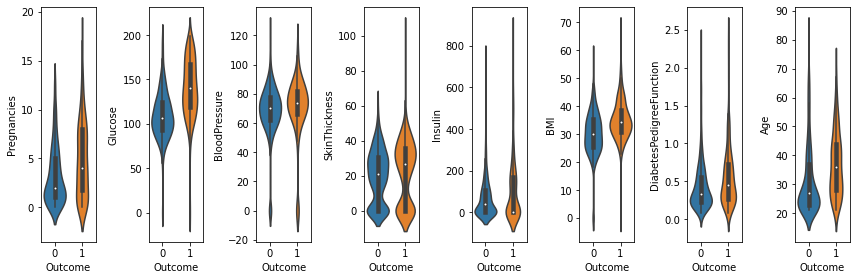

In [10]:
# Plot distribution of features
fig, axs = plt.subplots(1, 8, figsize=(12, 4))

for i, ax in enumerate(axs):
    sns.violinplot(ax=ax, data=df, x='Outcome', y=features[i])

fig.tight_layout()

In [11]:
# Helper function to work with data cleaning lambda
# For passed feature, updates 0 values to mean of feature for objects of same class
# Takes:
# - row: row of dataframe
# - feature: df column name
# - df: dataframe
def dataCleaningHelper(row, feature, df):
    # Check if feature value at row = 0 and class label of row = 0
    if row[feature] == 0 and row['Outcome'] == 0:
        # Update feature value to mean of feature for class label 0
        return df[(df['Outcome'] == 0) & (df[feature] != 0)][feature].mean()
    # Check if feature value at row = 0 and class label of row = 1
    elif row[feature] == 0 and row['Outcome'] == 1:
        # Update feature value to mean of feature for class label 1
        return df[(df['Outcome'] == 1) & (df[feature] != 0)][feature].mean()
    # Otherwise no update
    else:
        return row[feature]     

In [12]:
# Iterate over selected column headers
for feature in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    # Replace feature values of 0 with mean feature value of objects in same class
    df[feature] = df.apply(lambda row: dataCleaningHelper(row, feature, df), axis=1)

In [13]:
# Function to optimise algorithm hyperparameters
# Performs grid search with cross validation to evaluate hyperparameter combinations
# Takes:
# - algorithm: machine learning model object
# - searchSpace: dictionary containing hyperparameter names (keys) and list of values to search through (values)
# - X_train: training data feature values
# - y_train: training data class labels
def hyperparameterTuner(algorithm, searchSpace, X_train, y_train):
    # Initialise cross validator
    # Repeated to account for variance across samples
    # Stratified to ensure constant proportion of each classes in each fold
    crossValidator = RepeatedStratifiedKFold(n_splits=5, random_state=1, n_repeats=1) # update this before final
    # Initialise search
    # Grid search to perform exhaustive search of all hyperparameter combinations in searchSpace
    hyperparameterSearch = GridSearchCV(algorithm, searchSpace, scoring='accuracy', n_jobs=-1, cv=crossValidation)
    # Fit search with training data
    # Performs search over searchSpace
    hyperparameterSearch.fit(X_train, y_train)
    return hyperparameterSearch

In [14]:
# Helper function to compute and store evaluation metrics
# Takes:
# - confusion matrix: 2x2 array
# - name of algorithm used: str
def getEvaluationMetrics(confusionMatrix, algorithmName):
    # Extract counts of each result category from confusion matrix
    [tp, fp], [fn, tn] = confusionMatrix
    # Compute evaluation metrics
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fScore = (2*precision*recall)/(precision+recall)
    # Return metrics as dictionary
    return {'Algorithm':algorithmName, 'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F-Score':fScore}

In [15]:
# Initialise empty dataframe to store model evaluation metrics
evaluationDf = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F-Score'])

### KNN

In [134]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.20, shuffle=True, random_state=234)

print(f'% positive outcomes\n\
All data: {df[target][df[target] == 1].count()*100 / len(df[target]):.1f}%\n\
Training split: {y_train[y_train == 1].count()*100 / len(y_train):.1f}%\n\
Test split: {y_test[y_test == 1].count()*100 / len(y_test):.1f}%')

# for knn
scaler = MinMaxScaler() # StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

% positive outcomes
All data: 34.9%
Training split: 34.9%
Test split: 35.1%


In [116]:
# Define KNN hyperparameter search space
# Default values for parameters are shown in comments
searchSpace = {
#     'algorithm': 'auto',
#     'leaf_size': 30,
#     'metric': 'minkowski',
#     'metric_params': None,
#     'n_jobs': None,
    'n_neighbors': list(range(3,25,2)), # 'n_neighbors': 5,
    'p': [1, 2, 3], # 'p': 2,
    'weights': ['uniform', 'distance'] # 'weights': 'uniform'}
}

In [121]:
knnModel = KNeighborsClassifier()

knnModel.fit(X_train, y_train)

knnPredictions = knnModel.predict(X_test)
print(f'KNN test accuracy: {100*((knnPredictions==y_test).sum()/y_test.shape[0]):.2f}%')

search = hyperParameterTuner(knnModel, searchSpace, X_train, y_train)

optimumParameters = search.best_params_
print(optimumParameters)

results = pd.DataFrame(search.cv_results_)

knnModel = KNeighborsClassifier(
    n_neighbors=optimumParameters['n_neighbors'],
    p=optimumParameters['p'],
    weights=optimumParameters['weights']
)

knnModel.fit(X_train, y_train)

knnPredictions = knnModel.predict(X_test)
print(f'KNN test accuracy: {100*((knnPredictions==y_test).sum()/y_test.shape[0]):.2f}%')

KNN test accuracy: 83.12%
{'n_neighbors': 21, 'p': 1, 'weights': 'uniform'}
KNN test accuracy: 90.26%


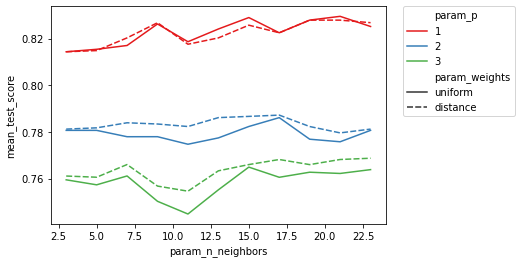

In [123]:
fig, ax = plt.subplots()

sns.lineplot(
    data=results,
    y='mean_test_score',
    x='param_n_neighbors',
    hue='param_p',
    style='param_weights',
    #ci='sd',
    #dashes=False,
    palette="Set1",
#     marker="o",
#     alpha=0.5,
    ax=ax,
)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax.set_xlabel("CV test fold", size=12, labelpad=10)
# ax.set_ylabel("Model AUC", size=12)
# ax.tick_params(bottom=True, labelbottom=False)
plt.show()

In [24]:
confusionMatrixKNN = confusion_matrix(y_test, knnPredictions)#, normalize='all')

# Confusion matrix whose i-th row and j-th column entry 
# indicates the number of samples with true label being i-th class 
# predicted label being j-th class.

evaluationDf = evaluationDf.append(getEvaluationMetrics(confusionMatrixKNN, 'KNN'), ignore_index=True)

### Random Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [133]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.20, shuffle=True, random_state=234)

print(f'% positive outcomes\n\
All data: {df[target][df[target] == 1].count()*100 / len(df[target]):.1f}%\n\
Training split: {y_train[y_train == 1].count()*100 / len(y_train):.1f}%\n\
Test split: {y_test[y_test == 1].count()*100 / len(y_test):.1f}%')

# for rf - not required?
scaler = None

% positive outcomes
All data: 34.9%
Training split: 34.9%
Test split: 35.1%


In [27]:
# Define Random Forest hyperparameter search space
# Default values for parameters are shown in comments
searchSpace = {
#     'bootstrap': True,
#     'ccp_alpha': 0.0,
#     'class_weight': None,
    'criterion': ['gini', 'entropy'], # 'criterion': 'gini',
#     'max_depth': None,
    'max_features': [1, 2, 3, 4, 5], # 'max_features': 'auto' (= square root of number of features)
#     'max_leaf_nodes': None,
#     'max_samples': None,
#     'min_impurity_decrease': 0.0,
#     'min_samples_leaf': 1,
#     'min_samples_split': 2,
#     'min_weight_fraction_leaf': 0.0,
    'n_estimators': [10, 100, 1000], # 'n_estimators': 100,
#     'n_jobs': None,
#     'oob_score': False,
#     'random_state': None,
#     'verbose': 0,
#     'warm_start': False
    }

In [28]:
rfModel = RandomForestClassifier()

rfModel.fit(X_train, y_train)

rfPredictions = rfModel.predict(X_test)
print(f'Baseline Random Forest test accuracy: {100*((rfPredictions==y_test).sum()/y_test.shape[0]):.2f}%')

search = hyperParameterTuner(rfModel, searchSpace, X_train, y_train)

optimumParameters = search.best_params_
print(optimumParameters)

results = pd.DataFrame(search.cv_results_)

rfModel = RandomForestClassifier(
    criterion=optimumParameters['criterion'],
    max_features=optimumParameters['max_features'],
    n_estimators=optimumParameters['n_estimators'],
)

rfModel.fit(X_train, y_train)

rfPredictions = rfModel.predict(X_test)
print(f'Random Forest test accuracy: {100*((rfPredictions==y_test).sum()/y_test.shape[0]):.2f}%')

Baseline Random Forest test accuracy: 88.02%
{'criterion': 'entropy', 'max_features': 3, 'n_estimators': 100}
Random Forest test accuracy: 87.50%


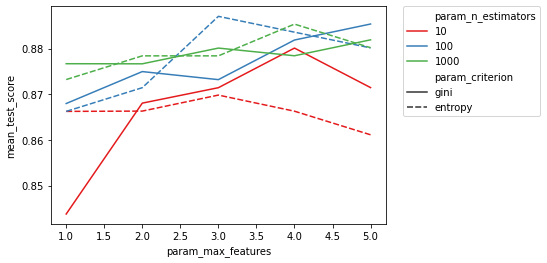

In [31]:
fig, ax = plt.subplots()

sns.lineplot(
    data=results,
    y='mean_test_score',
    x='param_max_features',
    hue='param_n_estimators',
    style='param_criterion',
    #dashes=False,
    palette="Set1",
#     marker="o",
#     alpha=0.5,
    ax=ax,
)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax.set_xlabel("CV test fold", size=12, labelpad=10)
# ax.set_ylabel("Model AUC", size=12)
# ax.tick_params(bottom=True, labelbottom=False)
plt.show()

In [ ]:
confusionMatrixRF = confusion_matrix(y_test, rfPredictions)

# Confusion matrix whose i-th row and j-th column entry 
# indicates the number of samples with true label being i-th class 
# predicted label being j-th class.

evaluationDf = evaluationDf.append(getEvaluationMetrics(confusionMatrixRF, 'Random Forest'), ignore_index=True)

## SVM
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df[features], 
                                                    df[target],
                                                    test_size=0.20, 
                                                    shuffle=True, 
                                                    random_state=123, 
                                                    stratify=df[target])

print(f'% positive outcomes\n\
All data: {df[target][df[target] == 1].count()*100 / len(df[target]):.1f}%\n\
Training split: {y_train[y_train == 1].count()*100 / len(y_train):.1f}%\n\
Test split: {y_test[y_test == 1].count()*100 / len(y_test):.1f}%')

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

% positive outcomes
All data: 34.9%
Training split: 34.9%
Test split: 35.1%


In [94]:
# Define Random Forest hyperparameter search space
# Default values for parameters are shown in comments
searchSpace = {
    'C': np.logspace(-2, 3, num=6), # 'C': 1.0,
#     'break_ties': False,
#     'cache_size': 200,
#     'class_weight': None,
#     'coef0': 0.0,
#     'decision_function_shape': 'ovr',
    'degree': [2, 3, 4], # 'degree': 3, (only used for polynomial kernel)
#     'gamma': 'scale',
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # 'kernel': 'rbf',
#     'max_iter': -1,
#     'probability': False,
#     'random_state': None,
#     'shrinking': True,
#     'tol': 0.001,
#     'verbose': False
}

In [95]:
svcModel = SVC()

svcModel.fit(X_train, y_train)

svcPredictions = svcModel.predict(X_test)
print(f'svc baseline test accuracy: {100*((svcPredictions==y_test).sum()/y_test.shape[0])}%') #:.2f

search = hyperParameterTuner(svcModel, searchSpace, X_train, y_train)

optimumParameters = search.best_params_
print(optimumParameters)

results = pd.DataFrame(search.cv_results_)

svcModel = SVC(
    C=optimumParameters['C'],
    kernel=optimumParameters['kernel'],
    degree=optimumParameters['degree'],
)

svcModel.fit(X_train, y_train)

svcPredictions = svcModel.predict(X_test)
print(f'svc tuned test accuracy: {100*((svcPredictions==y_test).sum()/y_test.shape[0])}%') #:.2f

svc baseline test accuracy: 79.6875%
{'C': 0.464158883361278, 'degree': 2, 'kernel': 'rbf'}
svc tuned test accuracy: 80.20833333333334%


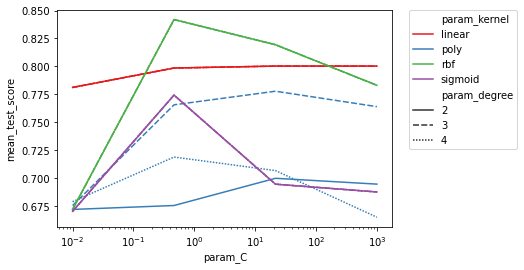

In [107]:
fig, ax = plt.subplots()

sns.lineplot(
    data=results,
    y='mean_test_score',
    x='param_C',
    hue='param_kernel',
    style='param_degree',
    ci='sd',#'std_test_score',
    #dashes=False,
    palette="Set1",
#     marker="o",
#     alpha=0.5,
    ax=ax,
)

ax.set(xscale="log")#, yscale="log")

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax.set_xlabel("CV test fold", size=12, labelpad=10)
# ax.set_ylabel("Model AUC", size=12)
# ax.tick_params(bottom=True, labelbottom=False)
plt.show()

In [99]:
confusionMatrixSVC = confusion_matrix(y_test, svcPredictions)

# Confusion matrix whose i-th row and j-th column entry 
# indicates the number of samples with true label being i-th class 
# predicted label being j-th class.

evaluationDf = evaluationDf.append(getEvaluationMetrics(confusionMatrixSVC, 'Support Vector Classification'), ignore_index=True)

### Evaluation

In [126]:
print(confusionMatrixKNN)

print(confusionMatrixRF)

print(confusionMatrixSVC)

[[96 10]
 [11 37]]


NameError: name 'confusionMatrixRF' is not defined

In [100]:
evaluationDf.set_index('Algorithm')

,Accuracy,Precision,Recall,F-Score
Algorithm,,,,
KNN,0.863636,0.905660,0.897196,0.901408
Naie Bayes,0.786458,0.824561,0.817391,0.820961
Support Vector Classification,0.802083,0.911504,0.786260,0.844262
